In [484]:
reset -fs

In [485]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [486]:
import pandas as pd
import numpy as np
import os
import glob

In [487]:
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [488]:
# import datasets from 2005-2009
path = r'speeding_data' 
all_files = glob.glob(path + "/*.csv")

In [489]:
# append all years
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, dtype={ "istatenum": str, "icity": str})
    df.columns = ['statenum','casenum', 'vnumber', 'pnumber', 'city', 'accdate', 'alcinvol', 'travspd']
    li.append(df)

speed1 = pd.concat(li, axis=0, ignore_index=True, sort = False)

In [490]:
# import datasets from 2010- 2017 (provided in a different format)
path = r'speeding_data/new/' 
all_files = glob.glob(path + "/*.csv")

In [491]:
# append 2010-2017 and append pre-2009 data as well
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, dtype={ "statenum": str, "casenum": str, "vnumber": str, \
                                                    "pnumber": str, "city": str, "accdate": str, "travspd": str})
    df.columns = ['statenum','casenum', 'vnumber', 'pnumber', 'city', 'accdate', 'alcinvol', 'travspd']
    li.append(df)

li.append(speed1)
speed2 = pd.concat(li, axis=0, ignore_index=True, sort = False)

In [492]:
# extract year from date
speed2['year'] = speed2['accdate'].str[-4:]
# change travelspeed to numeric and fill NA values with 0
speed2['travspd']=pd.to_numeric(speed2['travspd'],errors='coerce')
speed2['travspd']=speed2['travspd'].fillna(0).astype(int)
# drop missing values, outliers: (-1)Blank, (997)Greater Than 151 MPH, (998)Not Reported, (999)Unknown, 
#(0)Stopped Motor Vehicle In- Transport
speed2 = speed2.loc[(speed2.travspd != 997) & (speed2.travspd != 998) & (speed2.travspd != 999) & \
                    (speed2.travspd != -1) & (speed2.travspd != 0)]


In [493]:
# limit to 3 CA cities
speed2 = speed2.loc[(speed2.statenum == '6') & ((speed2.city == '3290') | (speed2.city == '3340')| \
                    (speed2.city == '1980'))]


In [504]:
# keep variables of interest
speed2 = speed2[['year','travspd']]

In [505]:
# aggregate median speed by year
speedmedian = speed2.groupby('year').median().reset_index()
# flag above and below speed limit = 65
speedmedian['above'] = 0
speedmedian.loc[(speedmedian.travspd > 65), 'above'] = 1

In [506]:
%R -i speed2 -i speedmedian

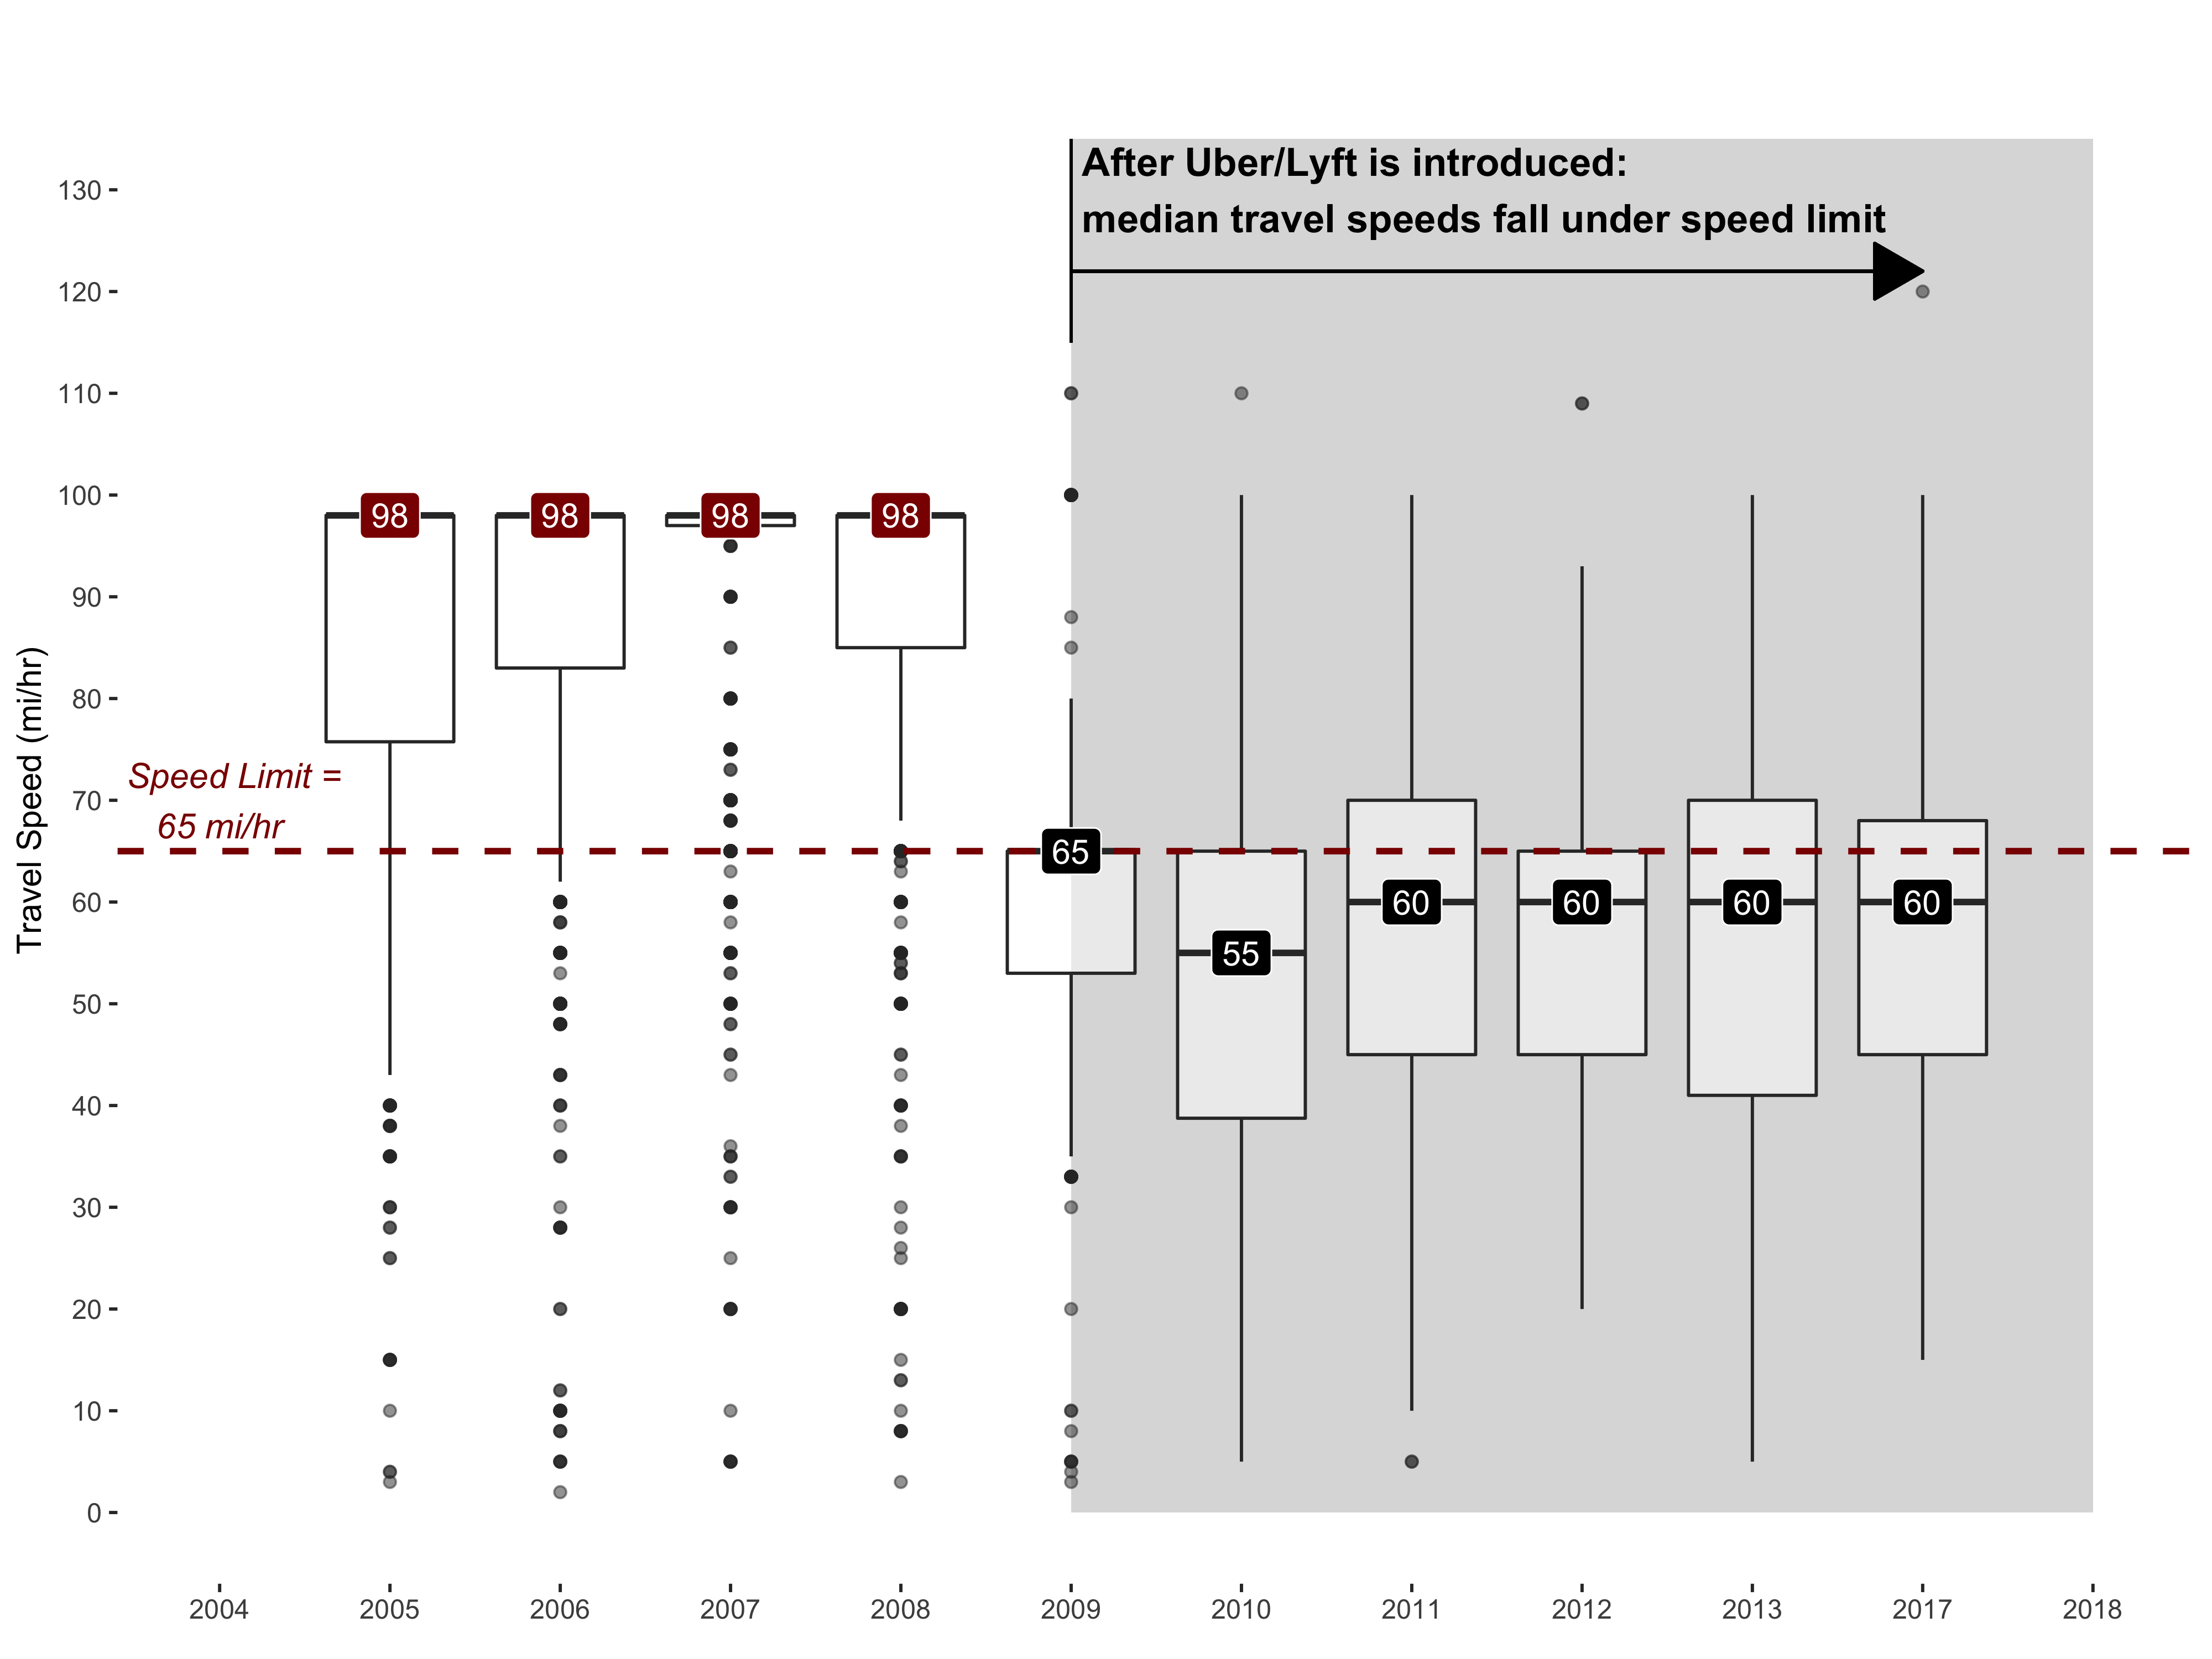

In [583]:
%%R -w 10 -h 7.5 --units in -r 400
ggplot() + 
    # shaded area
    annotate(geom ="rect", xmin = '2009', xmax = '2018', ymin = 0, ymax = 135, alpha = .8, fill = 'lightgrey') +
    # boxplot
    geom_boxplot(aes(x = year, y = travspd), alpha = 0.5, data = speed2) +
    # speed limit line
    geom_hline(yintercept = 65,  color = 'red4', size = 1, linetype = 'dashed')+
    # axis
    xlab(element_blank()) +
    ylab("Travel Speed (mi/hr)") +
    scale_y_continuous(limits = c(0, 140), breaks = seq(0, 135, by = 10)) +
    # median speed labels
    geom_label(aes(x = year, y = travspd, label = travspd, fill = factor(above)), , color = 'white', 
            data = speedmedian) +
    scale_fill_manual(values = c('black','darkred')) + 
    theme(panel.background = element_blank()) +
    guides(fill = F) +
    # text annotations
    annotate("text", x = '2004', y = 70, hjust = 0.5, label="   Speed Limit =\n65 mi/hr", size = 4, 
             fontface="italic", color = "darkred") + 
    annotate("text", x = '2009', y = 130, hjust = 0, 
             label=" After Uber/Lyft is introduced: \n median travel speeds fall under speed limit", 
             size = 4.5, fontface="bold") +
    # arrow
    geom_segment(aes(x = '2009', y = 122 , yend = 122 , xend = '2017'), arrow = arrow(type = 'closed'), 
            data = speedmedian) +
    geom_segment(aes(x = '2009', y = 115 , yend = 135 , xend = '2009'), data = speedmedian) +
    scale_x_discrete(limits = c('2004','2005','2006', '2007', '2008', '2009','2010','2011','2012','2013', '2017',
                                '2018')) 
    